<a href="https://colab.research.google.com/github/MPGarg/Assignment-14/blob/main/EVA8_Assignment_14.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install -q --upgrade transformers diffusers ftfy

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.0/7.0 MB 56.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 934.9/934.9 kB 12.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.1/53.1 kB 4.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 67.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 224.5/224.5 kB 17.5 MB/s eta 0:00:00


In [2]:
!pip install accelerate

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 215.3/215.3 kB 8.9 MB/s eta 0:00:00


In [3]:
from base64 import b64encode

import numpy
import torch
from diffusers import AutoencoderKL, LMSDiscreteScheduler, UNet2DConditionModel
from huggingface_hub import notebook_login

# For video display:
from IPython.display import HTML
from matplotlib import pyplot as plt
from pathlib import Path
from PIL import Image
from torch import autocast
from torchvision import transforms as tfms
from tqdm.auto import tqdm
from transformers import CLIPTextModel, CLIPTokenizer, logging

torch.manual_seed(1)
if not (Path.home()/'.huggingface'/'token').exists(): notebook_login()

# Supress some unnecessary warnings when loading the CLIPTextModel
logging.set_verbosity_error()

# Set device
torch_device = "cuda" if torch.cuda.is_available() else "cpu"

In [4]:
# Load the autoencoder model which will be used to decode the latents into image space. 
vae = AutoencoderKL.from_pretrained("CompVis/stable-diffusion-v1-4", subfolder="vae")

# Load the tokenizer and text encoder to tokenize and encode the text. 
tokenizer = CLIPTokenizer.from_pretrained("openai/clip-vit-large-patch14")
text_encoder = CLIPTextModel.from_pretrained("openai/clip-vit-large-patch14")

# The UNet model for generating the latents.
unet = UNet2DConditionModel.from_pretrained("CompVis/stable-diffusion-v1-4", subfolder="unet")

# The noise scheduler
scheduler = LMSDiscreteScheduler(beta_start=0.00085, beta_end=0.012, beta_schedule="scaled_linear", num_train_timesteps=1000)

# To the GPU we go!
vae = vae.to(torch_device)
text_encoder = text_encoder.to(torch_device)
unet = unet.to(torch_device)

# Functions

In [5]:
def pil_to_latent(input_im):
    # Single image -> single latent in a batch (so size 1, 4, 64, 64)
    with torch.no_grad():
        latent = vae.encode(tfms.ToTensor()(input_im).unsqueeze(0).to(torch_device)*2-1) # Note scaling
    return 0.18215 * latent.latent_dist.sample()

def latents_to_pil(latents):
    # bath of latents -> list of images
    latents = (1 / 0.18215) * latents
    with torch.no_grad():
        image = vae.decode(latents).sample
    image = (image / 2 + 0.5).clamp(0, 1)
    image = image.detach().cpu().permute(0, 2, 3, 1).numpy()
    images = (image * 255).round().astype("uint8")
    pil_images = [Image.fromarray(image) for image in images]
    return pil_images

In [6]:
def get_output_embeds(input_embeddings):
    # CLIP's text model uses causal mask, so we prepare it here:
    bsz, seq_len = input_embeddings.shape[:2]
    causal_attention_mask = text_encoder.text_model._build_causal_attention_mask(bsz, seq_len, dtype=input_embeddings.dtype)

    # Getting the output embeddings involves calling the model with passing output_hidden_states=True 
    # so that it doesn't just return the pooled final predictions:
    encoder_outputs = text_encoder.text_model.encoder(
        inputs_embeds=input_embeddings,
        attention_mask=None, # We aren't using an attention mask so that can be None
        causal_attention_mask=causal_attention_mask.to(torch_device),
        output_attentions=None,
        output_hidden_states=True, # We want the output embs not the final output
        return_dict=None,
    )

    # We're interested in the output hidden state only
    output = encoder_outputs[0]

    # There is a final layer norm we need to pass these through
    output = text_encoder.text_model.final_layer_norm(output)

    # And now they're ready!
    return output

In [7]:
#Generating an image with these modified embeddings

def generate_with_embs(text_embeddings):
    height = 512                        # default height of Stable Diffusion
    width = 512                         # default width of Stable Diffusion
    num_inference_steps = 50            # Number of denoising steps
    guidance_scale = 7.5                # Scale for classifier-free guidance
    generator = torch.manual_seed(64)   # Seed generator to create the inital latent noise
    batch_size = 1

    max_length = text_input.input_ids.shape[-1]
    uncond_input = tokenizer(
      [""] * batch_size, padding="max_length", max_length=max_length, return_tensors="pt"
    )
    with torch.no_grad():
        uncond_embeddings = text_encoder(uncond_input.input_ids.to(torch_device))[0] 
    text_embeddings = torch.cat([uncond_embeddings, text_embeddings])

    # Prep Scheduler
    scheduler.set_timesteps(num_inference_steps)

    # Prep latents
    latents = torch.randn(
    (batch_size, unet.config.in_channels, height // 8, width // 8),
    generator=generator,
    )
    latents = latents.to(torch_device)
    latents = latents * scheduler.init_noise_sigma

    # Loop
    for i, t in tqdm(enumerate(scheduler.timesteps)):
        # expand the latents if we are doing classifier-free guidance to avoid doing two forward passes.
        latent_model_input = torch.cat([latents] * 2)
        sigma = scheduler.sigmas[i]
        latent_model_input = scheduler.scale_model_input(latent_model_input, t)

        # predict the noise residual
        with torch.no_grad():
            noise_pred = unet(latent_model_input, t, encoder_hidden_states=text_embeddings)["sample"]

        # perform guidance
        noise_pred_uncond, noise_pred_text = noise_pred.chunk(2)
        noise_pred = noise_pred_uncond + guidance_scale * (noise_pred_text - noise_pred_uncond)

        # compute the previous noisy sample x_t -> x_t-1
        latents = scheduler.step(noise_pred, t, latents).prev_sample

    return latents_to_pil(latents)[0]

# Textual Inversion

In [59]:
prompt = 'dancing astronaut .'

# Tokenize
text_input = tokenizer(prompt, padding="max_length", max_length=tokenizer.model_max_length, truncation=True, return_tensors="pt")

In [60]:
# See the individual token
for t in text_input['input_ids'][0][:12]: # We'll just look at the first 7 to save you from a wall of '<|endoftext|>'
    print(t, tokenizer.decoder.get(int(t)))

tensor(49406) <|startoftext|>
tensor(6226) dancing</w>
tensor(18376) astronaut</w>
tensor(269) .</w>
tensor(49407) <|endoftext|>
tensor(49407) <|endoftext|>
tensor(49407) <|endoftext|>
tensor(49407) <|endoftext|>
tensor(49407) <|endoftext|>
tensor(49407) <|endoftext|>
tensor(49407) <|endoftext|>
tensor(49407) <|endoftext|>


In [61]:
# Access the embedding layer
token_emb_layer = text_encoder.text_model.embeddings.token_embedding

In [62]:
token_embeddings = token_emb_layer(text_input.input_ids.to(torch_device))

In [63]:
pos_emb_layer = text_encoder.text_model.embeddings.position_embedding
pos_emb_layer

Embedding(77, 768)

In [64]:
position_ids = text_encoder.text_model.embeddings.position_ids[:, :77]
position_embeddings = pos_emb_layer(position_ids)

## Without any Textual Inversion

0it [00:00, ?it/s]

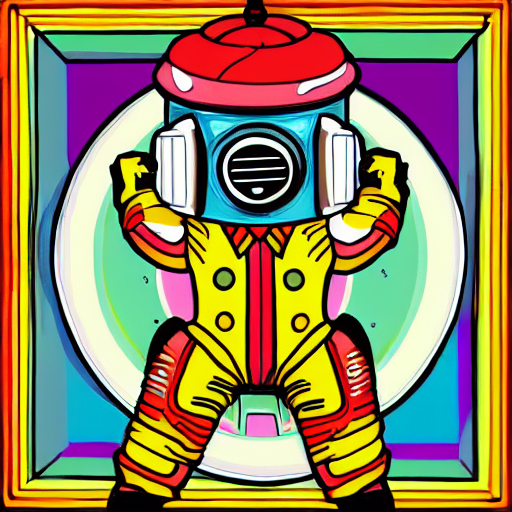

In [65]:
input_ids = text_input.input_ids.to(torch_device)

# Get token embeddings
token_embeddings = token_emb_layer(input_ids)

# Combine with pos embs
input_embeddings = token_embeddings + position_embeddings

#  Feed through to get final output embs
modified_output_embeddings = get_output_embeds(input_embeddings)

# And generate an image with this:
generate_with_embs(modified_output_embeddings)

In [66]:
replace_id=269  #replaced dot with Textual Inversion

## midjourney-style

In [67]:
x_embed = torch.load('learned_embeds_m.bin')
x_embed.keys(), x_embed['<midjourney-style>'].shape

(dict_keys(['<midjourney-style>']), torch.Size([768]))

0it [00:00, ?it/s]

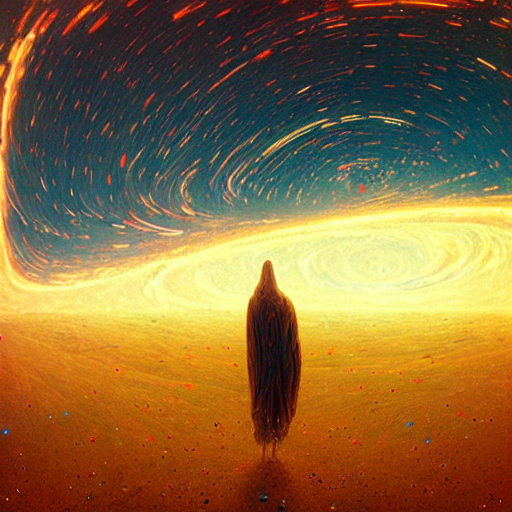

In [68]:
input_ids = text_input.input_ids.to(torch_device)

# Get token embeddings
token_embeddings = token_emb_layer(input_ids)

# The new embedding - our special birb word
replacement_token_embedding = x_embed['<midjourney-style>'].to(torch_device)

# Insert this into the token embeddings
token_embeddings[0, torch.where(input_ids[0]==replace_id)] = replacement_token_embedding.to(torch_device)

# Combine with pos embs
input_embeddings = token_embeddings + position_embeddings

#  Feed through to get final output embs
modified_output_embeddings = get_output_embeds(input_embeddings)

# And generate an image with this:
image1 = generate_with_embs(modified_output_embeddings)
image1

## hitokomoru-style

In [69]:
x_embed = torch.load('learned_embeds_h.bin')
x_embed.keys(), x_embed['<hitokomoru-style>'].shape

(dict_keys(['<hitokomoru-style>']), torch.Size([768]))

0it [00:00, ?it/s]

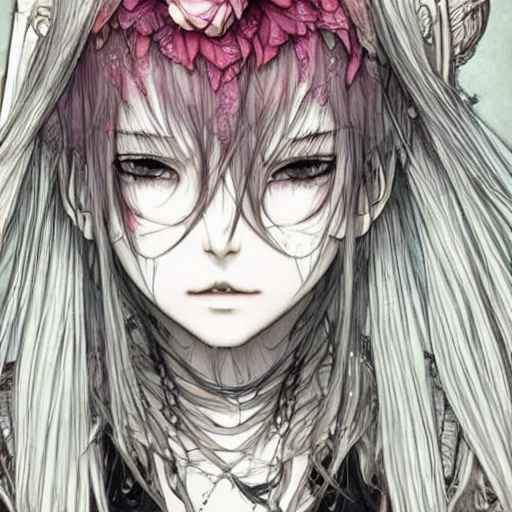

In [70]:
input_ids = text_input.input_ids.to(torch_device)

# Get token embeddings
token_embeddings = token_emb_layer(input_ids)

# The new embedding - our special birb word
replacement_token_embedding = x_embed['<hitokomoru-style>'].to(torch_device)

# Insert this into the token embeddings
token_embeddings[0, torch.where(input_ids[0]==replace_id)] = replacement_token_embedding.to(torch_device)

# Combine with pos embs
input_embeddings = token_embeddings + position_embeddings

#  Feed through to get final output embs
modified_output_embeddings = get_output_embeds(input_embeddings)

# And generate an image with this:
image2 = generate_with_embs(modified_output_embeddings)
image2

## birb-style

In [71]:
x_embed = torch.load('learned_embeds.bin')
x_embed.keys(), x_embed['<birb-style>'].shape

(dict_keys(['<birb-style>']), torch.Size([768]))

0it [00:00, ?it/s]

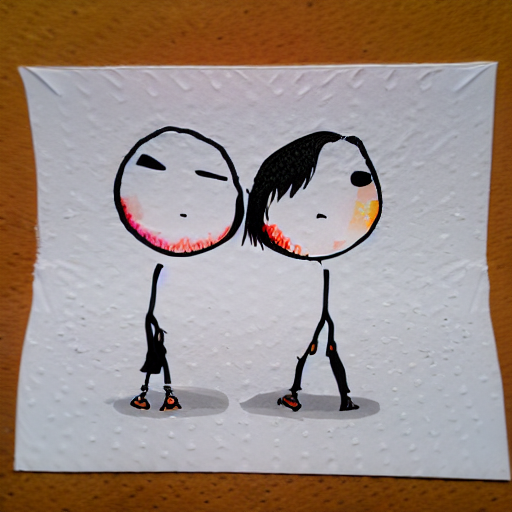

In [72]:
input_ids = text_input.input_ids.to(torch_device)

# Get token embeddings
token_embeddings = token_emb_layer(input_ids)

# The new embedding - our special birb word
replacement_token_embedding = x_embed['<birb-style>'].to(torch_device)

# Insert this into the token embeddings
token_embeddings[0, torch.where(input_ids[0]==replace_id)] = replacement_token_embedding.to(torch_device)

# Combine with pos embs
input_embeddings = token_embeddings + position_embeddings

#  Feed through to get final output embs
modified_output_embeddings = get_output_embeds(input_embeddings)

# And generate an image with this:
image3 = generate_with_embs(modified_output_embeddings)
image3

## summie-style

In [73]:
x_embed = torch.load('learned_embeds_s.bin')
x_embed.keys(), x_embed['<summie-style>'].shape

(dict_keys(['<summie-style>']), torch.Size([768]))

0it [00:00, ?it/s]

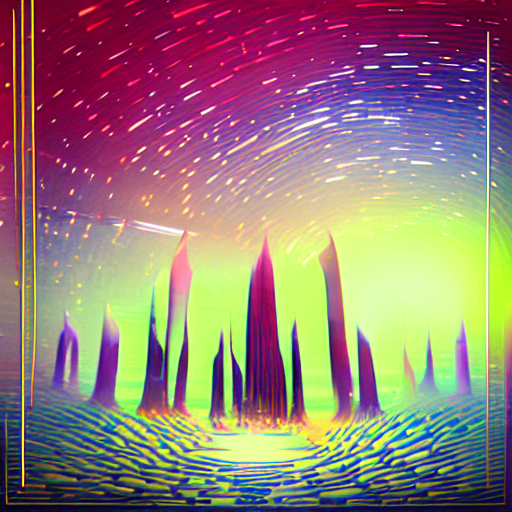

In [74]:
input_ids = text_input.input_ids.to(torch_device)

# Get token embeddings
token_embeddings = token_emb_layer(input_ids)

# The new embedding - our special birb word
replacement_token_embedding = x_embed['<summie-style>'].to(torch_device)

# Insert this into the token embeddings
token_embeddings[0, torch.where(input_ids[0]==replace_id)] = replacement_token_embedding.to(torch_device)

# Combine with pos embs
input_embeddings = token_embeddings + position_embeddings

#  Feed through to get final output embs
modified_output_embeddings = get_output_embeds(input_embeddings)

# And generate an image with this:
image4 = generate_with_embs(modified_output_embeddings)
image4

## illustration-style

In [75]:
x_embed = torch.load('learned_embeds_i.bin')
x_embed.keys(), x_embed['<illustration-style>'].shape

(dict_keys(['<illustration-style>']), torch.Size([768]))

0it [00:00, ?it/s]

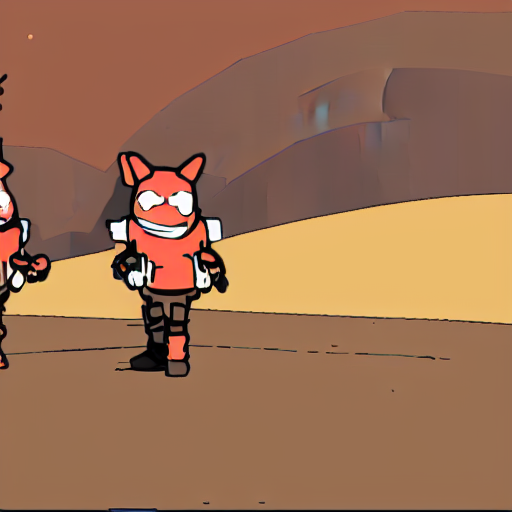

In [76]:
input_ids = text_input.input_ids.to(torch_device)

# Get token embeddings
token_embeddings = token_emb_layer(input_ids)

# The new embedding - our special birb word
replacement_token_embedding = x_embed['<illustration-style>'].to(torch_device)

# Insert this into the token embeddings
token_embeddings[0, torch.where(input_ids[0]==replace_id)] = replacement_token_embedding.to(torch_device)

# Combine with pos embs
input_embeddings = token_embeddings + position_embeddings

#  Feed through to get final output embs
modified_output_embeddings = get_output_embeds(input_embeddings)

# And generate an image with this:
image5 = generate_with_embs(modified_output_embeddings)
image5

## m-geo

In [77]:
x_embed = torch.load('learned_embeds_mg.bin')
x_embed.keys(),x_embed['<m-geo>'].shape

(dict_keys(['<m-geo>']), torch.Size([768]))

0it [00:00, ?it/s]

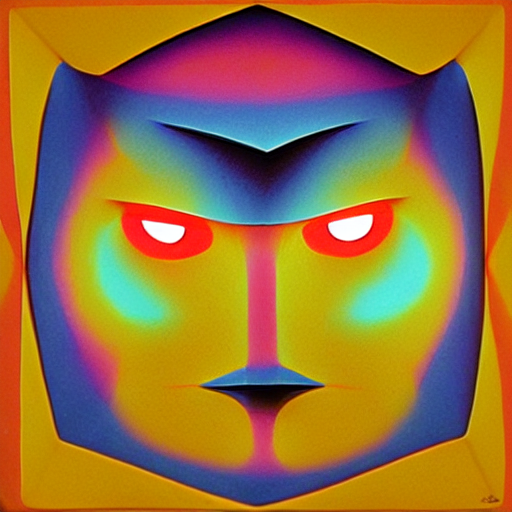

In [78]:
input_ids = text_input.input_ids.to(torch_device)

# Get token embeddings
token_embeddings = token_emb_layer(input_ids)

# The new embedding - our special birb word
replacement_token_embedding = x_embed['<m-geo>'].to(torch_device)

# Insert this into the token embeddings
token_embeddings[0, torch.where(input_ids[0]==replace_id)] = replacement_token_embedding.to(torch_device)

# Combine with pos embs
input_embeddings = token_embeddings + position_embeddings

#  Feed through to get final output embs
modified_output_embeddings = get_output_embeds(input_embeddings)

# And generate an image with this:
image6 = generate_with_embs(modified_output_embeddings)
image6

# Embedding of Mermaid using same model. 
## Loss function is designed by comparing difference in generated image & mermaid image

0it [00:00, ?it/s]

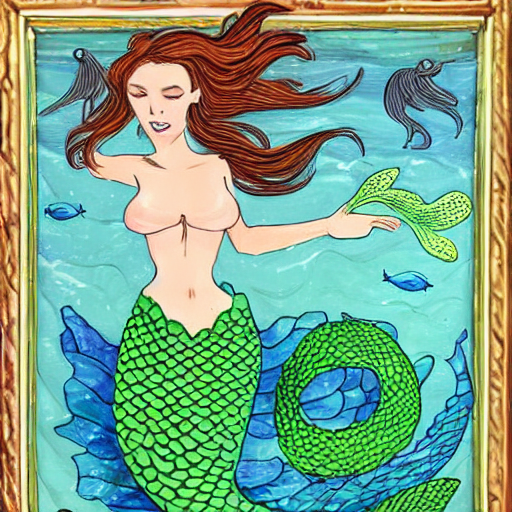

In [79]:
prompt1 = 'mermaid'

# Tokenize
text_input1 = tokenizer(prompt1, padding="max_length", max_length=tokenizer.model_max_length, truncation=True, return_tensors="pt")

# Access the embedding layer
token_emb_layer = text_encoder.text_model.embeddings.token_embedding

pos_emb_layer = text_encoder.text_model.embeddings.position_embedding
position_ids = text_encoder.text_model.embeddings.position_ids[:, :77]
position_embeddings1 = pos_emb_layer(position_ids)

input_ids1 = text_input1.input_ids.to(torch_device)

# Get token embeddings
token_embeddings1 = token_emb_layer(input_ids1)

# Combine with pos embs
input_embeddings1 = token_embeddings1 + position_embeddings1

#  Feed through to get final output embs
modified_output_embeddings1 = get_output_embeds(input_embeddings1)

# And generate an image with this:
ref_image = generate_with_embs(modified_output_embeddings1)	
ref_image

In [80]:
ref_latent = pil_to_latent(ref_image)

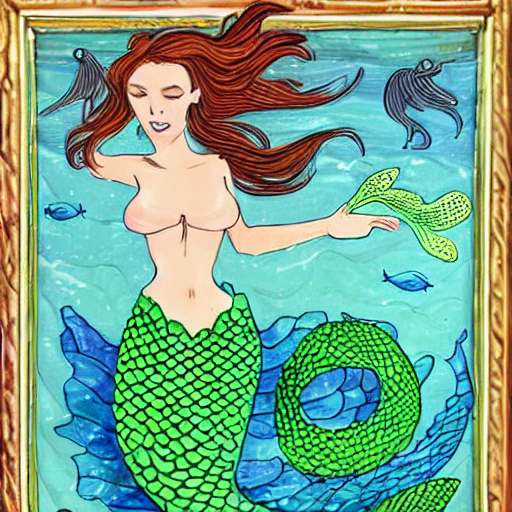

In [81]:
latents_to_pil(ref_latent)[0]

## Loss Function

In [82]:
def ref_loss(images,ref_image):
    # Reference image
    error = torch.abs(images - ref_image).mean() 
    return error

In [ ]:
print(ref_image)

<PIL.Image.Image image mode=RGB size=512x512 at 0x7FB1D30E64D0>


# Image Generation using loss function

0it [00:00, ?it/s]

0 loss: 69.70071411132812
10 loss: 57.28668975830078
20 loss: 58.38536071777344
30 loss: 52.18292999267578
40 loss: 50.99176788330078


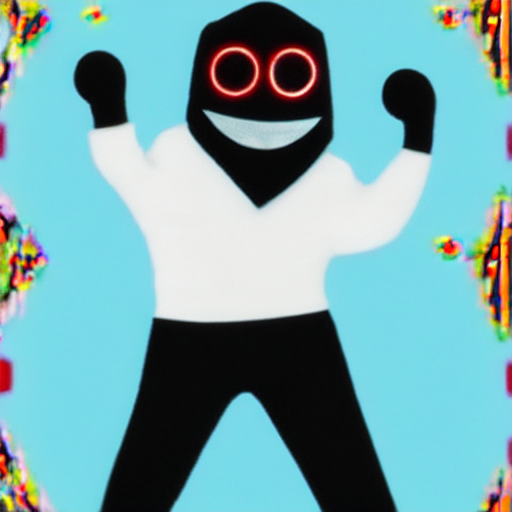

In [83]:
height = 512                        # default height of Stable Diffusion
width = 512                         # default width of Stable Diffusion
num_inference_steps = 50  #           # Number of denoising steps
guidance_scale = 8 #               # Scale for classifier-free guidance
generator = torch.manual_seed(64)   # Seed generator to create the inital latent noise
batch_size = 1
blue_loss_scale = 200 #

# Prep text 
text_input = tokenizer([prompt], padding="max_length", max_length=tokenizer.model_max_length, truncation=True, return_tensors="pt")
with torch.no_grad():
    text_embeddings = text_encoder(text_input.input_ids.to(torch_device))[0]

# And the uncond. input as before:
max_length = text_input.input_ids.shape[-1]
uncond_input = tokenizer(
    [""] * batch_size, padding="max_length", max_length=max_length, return_tensors="pt"
)
with torch.no_grad():
    uncond_embeddings = text_encoder(uncond_input.input_ids.to(torch_device))[0] 
text_embeddings = torch.cat([uncond_embeddings, text_embeddings])

# Prep Scheduler
scheduler.set_timesteps(num_inference_steps)

# Prep latents
latents = torch.randn(
  (batch_size, unet.config.in_channels, height // 8, width // 8),
  generator=generator,
)
latents = latents.to(torch_device)
latents = latents * scheduler.init_noise_sigma

# Loop
for i, t in tqdm(enumerate(scheduler.timesteps)):
    # expand the latents if we are doing classifier-free guidance to avoid doing two forward passes.
    latent_model_input = torch.cat([latents] * 2)
    sigma = scheduler.sigmas[i]
    latent_model_input = scheduler.scale_model_input(latent_model_input, t)

    # predict the noise residual
    with torch.no_grad():
        noise_pred = unet(latent_model_input, t, encoder_hidden_states=text_embeddings)["sample"]

    # perform CFG
    noise_pred_uncond, noise_pred_text = noise_pred.chunk(2)
    noise_pred = noise_pred_uncond + guidance_scale * (noise_pred_text - noise_pred_uncond)
    
    #### ADDITIONAL GUIDANCE ###
    if i%5 == 0:
        # Requires grad on the latents
        latents = latents.detach().requires_grad_()

        # Get the predicted x0:
        # latents_x0 = latents - sigma * noise_pred
        latents_x0 = scheduler.step(noise_pred, t, latents).pred_original_sample

        # Decode to image space
        denoised_images = vae.decode((1 / 0.18215) * latents_x0).sample / 2 + 0.5 # range (0, 1)

        #ref image
        with torch.no_grad():
          ref_images = vae.decode((1 / 0.18215) * ref_latent).sample / 2 + 0.5 # range (0, 1)

        # Calculate loss
        loss = ref_loss(denoised_images,ref_images) * blue_loss_scale
        
        # Occasionally print it out
        if i%10==0:
            print(i, 'loss:', loss.item())

        # Get gradient
        cond_grad = torch.autograd.grad(loss, latents)[0]

        # Modify the latents based on this gradient
        latents = latents.detach() - cond_grad * sigma**2
    
    # Now step with scheduler
    latents = scheduler.step(noise_pred, t, latents).prev_sample


latents_to_pil(latents)[0]

In [90]:
x_embed = torch.load('learned_embeds_m.bin')
x_embed.keys()

dict_keys(['<midjourney-style>'])

0it [00:00, ?it/s]

0 loss: 77.96060180664062
10 loss: 50.15422058105469
20 loss: 48.396705627441406
30 loss: 47.60725402832031
40 loss: 46.69660949707031


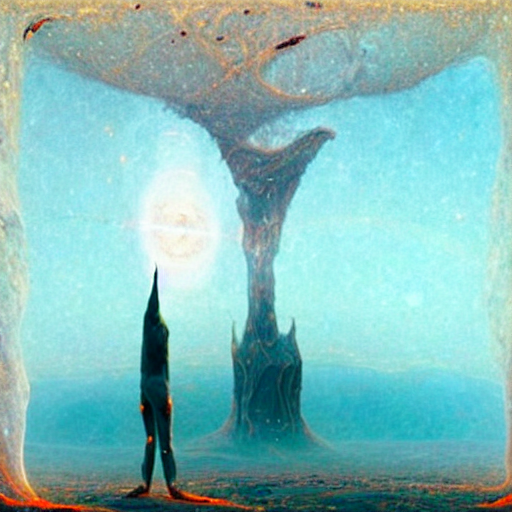

In [91]:
#prompt = 'A campfire (oil on canvas)' #
height = 512                        # default height of Stable Diffusion
width = 512                         # default width of Stable Diffusion
num_inference_steps = 50  #           # Number of denoising steps
guidance_scale = 8 #               # Scale for classifier-free guidance
generator = torch.manual_seed(64)   # Seed generator to create the inital latent noise
batch_size = 1
blue_loss_scale = 200 #

# Prep text 
text_input = tokenizer([prompt], padding="max_length", max_length=tokenizer.model_max_length, truncation=True, return_tensors="pt")
with torch.no_grad():
    text_embeddings = text_encoder(text_input.input_ids.to(torch_device))[0]

input_ids = text_input.input_ids.to(torch_device)

# Get token embeddings
token_embeddings = token_emb_layer(input_ids)

# The new embedding - our special birb word
replacement_token_embedding = x_embed['<midjourney-style>'].to(torch_device)

# Insert this into the token embeddings
token_embeddings[0, torch.where(input_ids[0]==replace_id)] = replacement_token_embedding.to(torch_device)

# Combine with pos embs
input_embeddings = token_embeddings + position_embeddings

#  Feed through to get final output embs
modified_output_embeddings = get_output_embeds(input_embeddings)

# And the uncond. input as before:
max_length = text_input.input_ids.shape[-1]
uncond_input = tokenizer(
    [""] * batch_size, padding="max_length", max_length=max_length, return_tensors="pt"
)
with torch.no_grad():
    uncond_embeddings = text_encoder(uncond_input.input_ids.to(torch_device))[0] 
    
text_embeddings = torch.cat([uncond_embeddings, modified_output_embeddings])

# Prep Scheduler
scheduler.set_timesteps(num_inference_steps)

# Prep latents
latents = torch.randn(
  (batch_size, unet.config.in_channels, height // 8, width // 8),
  generator=generator,
)
latents = latents.to(torch_device)
latents = latents * scheduler.init_noise_sigma

# Loop
for i, t in tqdm(enumerate(scheduler.timesteps)):
    # expand the latents if we are doing classifier-free guidance to avoid doing two forward passes.
    latent_model_input = torch.cat([latents] * 2)
    sigma = scheduler.sigmas[i]
    latent_model_input = scheduler.scale_model_input(latent_model_input, t)

    # predict the noise residual
    with torch.no_grad():
        noise_pred = unet(latent_model_input, t, encoder_hidden_states=text_embeddings)["sample"]

    # perform CFG
    noise_pred_uncond, noise_pred_text = noise_pred.chunk(2)
    noise_pred = noise_pred_uncond + guidance_scale * (noise_pred_text - noise_pred_uncond)
    
    #### ADDITIONAL GUIDANCE ###
    if i%5 == 0:
        # Requires grad on the latents
        latents = latents.detach().requires_grad_()

        # Get the predicted x0:
        # latents_x0 = latents - sigma * noise_pred
        latents_x0 = scheduler.step(noise_pred, t, latents).pred_original_sample

        # Decode to image space
        denoised_images = vae.decode((1 / 0.18215) * latents_x0).sample / 2 + 0.5 # range (0, 1)

        #ref image
        with torch.no_grad():
          ref_images = vae.decode((1 / 0.18215) * ref_latent).sample / 2 + 0.5 # range (0, 1)

        # Calculate loss
        loss = ref_loss(denoised_images,ref_images) * blue_loss_scale
        
        # Occasionally print it out
        if i%10==0:
            print(i, 'loss:', loss.item())

        # Get gradient
        cond_grad = torch.autograd.grad(loss, latents)[0]

        # Modify the latents based on this gradient
        latents = latents.detach() - cond_grad * sigma**2
    
    # Now step with scheduler
    latents = scheduler.step(noise_pred, t, latents).prev_sample


latents_to_pil(latents)[0]

In [92]:
x_embed = torch.load('learned_embeds_h.bin')
x_embed.keys()

dict_keys(['<hitokomoru-style>'])

0it [00:00, ?it/s]

0 loss: 68.09982299804688
10 loss: 56.73509979248047
20 loss: 54.66909408569336
30 loss: 54.12366485595703
40 loss: 53.78105545043945


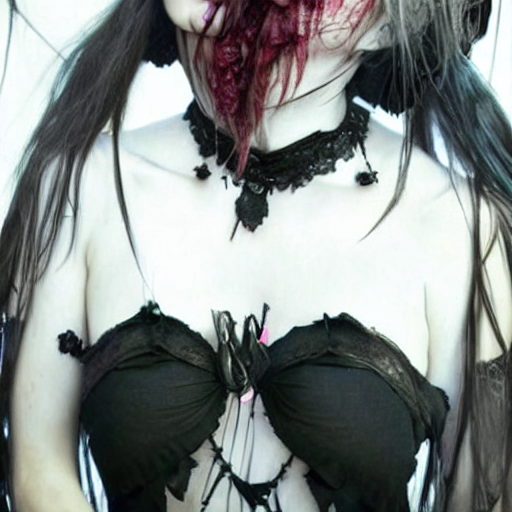

In [93]:
#prompt = 'A campfire (oil on canvas)' #
height = 512                        # default height of Stable Diffusion
width = 512                         # default width of Stable Diffusion
num_inference_steps = 50  #           # Number of denoising steps
guidance_scale = 8 #               # Scale for classifier-free guidance
generator = torch.manual_seed(64)   # Seed generator to create the inital latent noise
batch_size = 1
blue_loss_scale = 200 #

# Prep text 
text_input = tokenizer([prompt], padding="max_length", max_length=tokenizer.model_max_length, truncation=True, return_tensors="pt")
with torch.no_grad():
    text_embeddings = text_encoder(text_input.input_ids.to(torch_device))[0]

input_ids = text_input.input_ids.to(torch_device)

# Get token embeddings
token_embeddings = token_emb_layer(input_ids)

# The new embedding - our special birb word
replacement_token_embedding = x_embed['<hitokomoru-style>'].to(torch_device)

# Insert this into the token embeddings
token_embeddings[0, torch.where(input_ids[0]==replace_id)] = replacement_token_embedding.to(torch_device)

# Combine with pos embs
input_embeddings = token_embeddings + position_embeddings

#  Feed through to get final output embs
modified_output_embeddings = get_output_embeds(input_embeddings)

# And the uncond. input as before:
max_length = text_input.input_ids.shape[-1]
uncond_input = tokenizer(
    [""] * batch_size, padding="max_length", max_length=max_length, return_tensors="pt"
)
with torch.no_grad():
    uncond_embeddings = text_encoder(uncond_input.input_ids.to(torch_device))[0] 
    
text_embeddings = torch.cat([uncond_embeddings, modified_output_embeddings])

# Prep Scheduler
scheduler.set_timesteps(num_inference_steps)

# Prep latents
latents = torch.randn(
  (batch_size, unet.config.in_channels, height // 8, width // 8),
  generator=generator,
)
latents = latents.to(torch_device)
latents = latents * scheduler.init_noise_sigma

# Loop
for i, t in tqdm(enumerate(scheduler.timesteps)):
    # expand the latents if we are doing classifier-free guidance to avoid doing two forward passes.
    latent_model_input = torch.cat([latents] * 2)
    sigma = scheduler.sigmas[i]
    latent_model_input = scheduler.scale_model_input(latent_model_input, t)

    # predict the noise residual
    with torch.no_grad():
        noise_pred = unet(latent_model_input, t, encoder_hidden_states=text_embeddings)["sample"]

    # perform CFG
    noise_pred_uncond, noise_pred_text = noise_pred.chunk(2)
    noise_pred = noise_pred_uncond + guidance_scale * (noise_pred_text - noise_pred_uncond)
    
    #### ADDITIONAL GUIDANCE ###
    if i%5 == 0:
        # Requires grad on the latents
        latents = latents.detach().requires_grad_()

        # Get the predicted x0:
        # latents_x0 = latents - sigma * noise_pred
        latents_x0 = scheduler.step(noise_pred, t, latents).pred_original_sample

        # Decode to image space
        denoised_images = vae.decode((1 / 0.18215) * latents_x0).sample / 2 + 0.5 # range (0, 1)

        #ref image
        with torch.no_grad():
          ref_images = vae.decode((1 / 0.18215) * ref_latent).sample / 2 + 0.5 # range (0, 1)

        # Calculate loss
        loss = ref_loss(denoised_images,ref_images) * blue_loss_scale
        
        # Occasionally print it out
        if i%10==0:
            print(i, 'loss:', loss.item())

        # Get gradient
        cond_grad = torch.autograd.grad(loss, latents)[0]

        # Modify the latents based on this gradient
        latents = latents.detach() - cond_grad * sigma**2
    
    # Now step with scheduler
    latents = scheduler.step(noise_pred, t, latents).prev_sample


latents_to_pil(latents)[0]

In [94]:
x_embed = torch.load('learned_embeds.bin')
x_embed.keys()

dict_keys(['<birb-style>'])

0it [00:00, ?it/s]

0 loss: 65.05396270751953
10 loss: 59.86819839477539
20 loss: 64.31321716308594
30 loss: 62.663482666015625
40 loss: 61.688995361328125


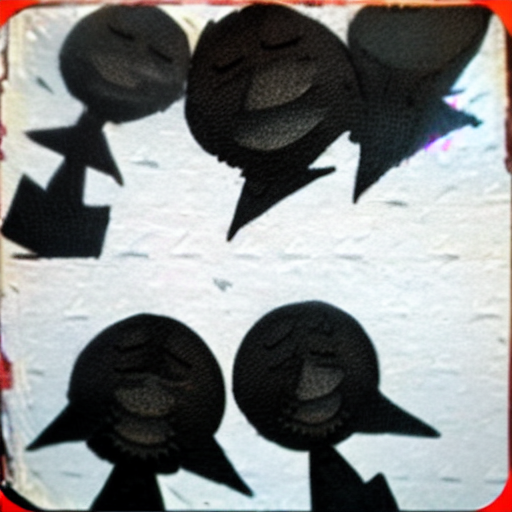

In [95]:
#prompt = 'A campfire (oil on canvas)' #
height = 512                        # default height of Stable Diffusion
width = 512                         # default width of Stable Diffusion
num_inference_steps = 50  #           # Number of denoising steps
guidance_scale = 8 #               # Scale for classifier-free guidance
generator = torch.manual_seed(64)   # Seed generator to create the inital latent noise
batch_size = 1
blue_loss_scale = 200 #

# Prep text 
text_input = tokenizer([prompt], padding="max_length", max_length=tokenizer.model_max_length, truncation=True, return_tensors="pt")
with torch.no_grad():
    text_embeddings = text_encoder(text_input.input_ids.to(torch_device))[0]

input_ids = text_input.input_ids.to(torch_device)

# Get token embeddings
token_embeddings = token_emb_layer(input_ids)

# The new embedding - our special birb word
replacement_token_embedding = x_embed['<birb-style>'].to(torch_device)

# Insert this into the token embeddings
token_embeddings[0, torch.where(input_ids[0]==replace_id)] = replacement_token_embedding.to(torch_device)

# Combine with pos embs
input_embeddings = token_embeddings + position_embeddings

#  Feed through to get final output embs
modified_output_embeddings = get_output_embeds(input_embeddings)

# And the uncond. input as before:
max_length = text_input.input_ids.shape[-1]
uncond_input = tokenizer(
    [""] * batch_size, padding="max_length", max_length=max_length, return_tensors="pt"
)
with torch.no_grad():
    uncond_embeddings = text_encoder(uncond_input.input_ids.to(torch_device))[0] 
    
text_embeddings = torch.cat([uncond_embeddings, modified_output_embeddings])

# Prep Scheduler
scheduler.set_timesteps(num_inference_steps)

# Prep latents
latents = torch.randn(
  (batch_size, unet.config.in_channels, height // 8, width // 8),
  generator=generator,
)
latents = latents.to(torch_device)
latents = latents * scheduler.init_noise_sigma

# Loop
for i, t in tqdm(enumerate(scheduler.timesteps)):
    # expand the latents if we are doing classifier-free guidance to avoid doing two forward passes.
    latent_model_input = torch.cat([latents] * 2)
    sigma = scheduler.sigmas[i]
    latent_model_input = scheduler.scale_model_input(latent_model_input, t)

    # predict the noise residual
    with torch.no_grad():
        noise_pred = unet(latent_model_input, t, encoder_hidden_states=text_embeddings)["sample"]

    # perform CFG
    noise_pred_uncond, noise_pred_text = noise_pred.chunk(2)
    noise_pred = noise_pred_uncond + guidance_scale * (noise_pred_text - noise_pred_uncond)
    
    #### ADDITIONAL GUIDANCE ###
    if i%5 == 0:
        # Requires grad on the latents
        latents = latents.detach().requires_grad_()

        # Get the predicted x0:
        # latents_x0 = latents - sigma * noise_pred
        latents_x0 = scheduler.step(noise_pred, t, latents).pred_original_sample

        # Decode to image space
        denoised_images = vae.decode((1 / 0.18215) * latents_x0).sample / 2 + 0.5 # range (0, 1)

        #ref image
        with torch.no_grad():
          ref_images = vae.decode((1 / 0.18215) * ref_latent).sample / 2 + 0.5 # range (0, 1)

        # Calculate loss
        loss = ref_loss(denoised_images,ref_images) * blue_loss_scale
        
        # Occasionally print it out
        if i%10==0:
            print(i, 'loss:', loss.item())

        # Get gradient
        cond_grad = torch.autograd.grad(loss, latents)[0]

        # Modify the latents based on this gradient
        latents = latents.detach() - cond_grad * sigma**2
    
    # Now step with scheduler
    latents = scheduler.step(noise_pred, t, latents).prev_sample


latents_to_pil(latents)[0]

In [96]:
x_embed = torch.load('learned_embeds_s.bin')
x_embed.keys(), x_embed['<summie-style>'].shape

(dict_keys(['<summie-style>']), torch.Size([768]))

0it [00:00, ?it/s]

0 loss: 67.3162841796875
10 loss: 48.376346588134766
20 loss: 44.951786041259766
30 loss: 42.68345642089844
40 loss: 41.57463836669922


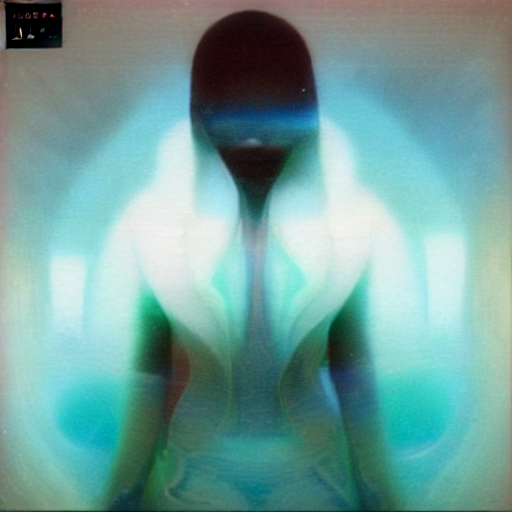

In [97]:
#prompt = 'A campfire (oil on canvas)' #
height = 512                        # default height of Stable Diffusion
width = 512                         # default width of Stable Diffusion
num_inference_steps = 50  #           # Number of denoising steps
guidance_scale = 8 #               # Scale for classifier-free guidance
generator = torch.manual_seed(64)   # Seed generator to create the inital latent noise
batch_size = 1
blue_loss_scale = 200 #

# Prep text 
text_input = tokenizer([prompt], padding="max_length", max_length=tokenizer.model_max_length, truncation=True, return_tensors="pt")
with torch.no_grad():
    text_embeddings = text_encoder(text_input.input_ids.to(torch_device))[0]

input_ids = text_input.input_ids.to(torch_device)

# Get token embeddings
token_embeddings = token_emb_layer(input_ids)

# The new embedding - our special birb word
replacement_token_embedding = x_embed['<summie-style>'].to(torch_device)

# Insert this into the token embeddings
token_embeddings[0, torch.where(input_ids[0]==replace_id)] = replacement_token_embedding.to(torch_device)

# Combine with pos embs
input_embeddings = token_embeddings + position_embeddings

#  Feed through to get final output embs
modified_output_embeddings = get_output_embeds(input_embeddings)

# And the uncond. input as before:
max_length = text_input.input_ids.shape[-1]
uncond_input = tokenizer(
    [""] * batch_size, padding="max_length", max_length=max_length, return_tensors="pt"
)
with torch.no_grad():
    uncond_embeddings = text_encoder(uncond_input.input_ids.to(torch_device))[0] 
    
text_embeddings = torch.cat([uncond_embeddings, modified_output_embeddings])

# Prep Scheduler
scheduler.set_timesteps(num_inference_steps)

# Prep latents
latents = torch.randn(
  (batch_size, unet.config.in_channels, height // 8, width // 8),
  generator=generator,
)
latents = latents.to(torch_device)
latents = latents * scheduler.init_noise_sigma

# Loop
for i, t in tqdm(enumerate(scheduler.timesteps)):
    # expand the latents if we are doing classifier-free guidance to avoid doing two forward passes.
    latent_model_input = torch.cat([latents] * 2)
    sigma = scheduler.sigmas[i]
    latent_model_input = scheduler.scale_model_input(latent_model_input, t)

    # predict the noise residual
    with torch.no_grad():
        noise_pred = unet(latent_model_input, t, encoder_hidden_states=text_embeddings)["sample"]

    # perform CFG
    noise_pred_uncond, noise_pred_text = noise_pred.chunk(2)
    noise_pred = noise_pred_uncond + guidance_scale * (noise_pred_text - noise_pred_uncond)
    
    #### ADDITIONAL GUIDANCE ###
    if i%5 == 0:
        # Requires grad on the latents
        latents = latents.detach().requires_grad_()

        # Get the predicted x0:
        # latents_x0 = latents - sigma * noise_pred
        latents_x0 = scheduler.step(noise_pred, t, latents).pred_original_sample

        # Decode to image space
        denoised_images = vae.decode((1 / 0.18215) * latents_x0).sample / 2 + 0.5 # range (0, 1)

        #ref image
        with torch.no_grad():
          ref_images = vae.decode((1 / 0.18215) * ref_latent).sample / 2 + 0.5 # range (0, 1)

        # Calculate loss
        loss = ref_loss(denoised_images,ref_images) * blue_loss_scale
        
        # Occasionally print it out
        if i%10==0:
            print(i, 'loss:', loss.item())

        # Get gradient
        cond_grad = torch.autograd.grad(loss, latents)[0]

        # Modify the latents based on this gradient
        latents = latents.detach() - cond_grad * sigma**2
    
    # Now step with scheduler
    latents = scheduler.step(noise_pred, t, latents).prev_sample


latents_to_pil(latents)[0]

In [98]:
x_embed = torch.load('learned_embeds_i.bin')
x_embed.keys()

dict_keys(['<illustration-style>'])

0it [00:00, ?it/s]

0 loss: 82.50460052490234
10 loss: 47.85344696044922
20 loss: 46.53655242919922
30 loss: 46.40371322631836
40 loss: 45.826988220214844


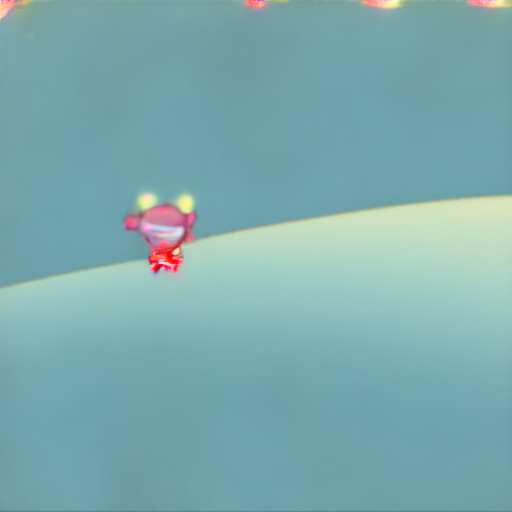

In [99]:
#prompt = 'A campfire (oil on canvas)' #
height = 512                        # default height of Stable Diffusion
width = 512                         # default width of Stable Diffusion
num_inference_steps = 50  #           # Number of denoising steps
guidance_scale = 8 #               # Scale for classifier-free guidance
generator = torch.manual_seed(64)   # Seed generator to create the inital latent noise
batch_size = 1
blue_loss_scale = 200 #

# Prep text 
text_input = tokenizer([prompt], padding="max_length", max_length=tokenizer.model_max_length, truncation=True, return_tensors="pt")
with torch.no_grad():
    text_embeddings = text_encoder(text_input.input_ids.to(torch_device))[0]

input_ids = text_input.input_ids.to(torch_device)

# Get token embeddings
token_embeddings = token_emb_layer(input_ids)

# The new embedding - our special birb word
replacement_token_embedding = x_embed['<illustration-style>'].to(torch_device)

# Insert this into the token embeddings
token_embeddings[0, torch.where(input_ids[0]==replace_id)] = replacement_token_embedding.to(torch_device)

# Combine with pos embs
input_embeddings = token_embeddings + position_embeddings

#  Feed through to get final output embs
modified_output_embeddings = get_output_embeds(input_embeddings)

# And the uncond. input as before:
max_length = text_input.input_ids.shape[-1]
uncond_input = tokenizer(
    [""] * batch_size, padding="max_length", max_length=max_length, return_tensors="pt"
)
with torch.no_grad():
    uncond_embeddings = text_encoder(uncond_input.input_ids.to(torch_device))[0] 
    
text_embeddings = torch.cat([uncond_embeddings, modified_output_embeddings])

# Prep Scheduler
scheduler.set_timesteps(num_inference_steps)

# Prep latents
latents = torch.randn(
  (batch_size, unet.config.in_channels, height // 8, width // 8),
  generator=generator,
)
latents = latents.to(torch_device)
latents = latents * scheduler.init_noise_sigma

# Loop
for i, t in tqdm(enumerate(scheduler.timesteps)):
    # expand the latents if we are doing classifier-free guidance to avoid doing two forward passes.
    latent_model_input = torch.cat([latents] * 2)
    sigma = scheduler.sigmas[i]
    latent_model_input = scheduler.scale_model_input(latent_model_input, t)

    # predict the noise residual
    with torch.no_grad():
        noise_pred = unet(latent_model_input, t, encoder_hidden_states=text_embeddings)["sample"]

    # perform CFG
    noise_pred_uncond, noise_pred_text = noise_pred.chunk(2)
    noise_pred = noise_pred_uncond + guidance_scale * (noise_pred_text - noise_pred_uncond)
    
    #### ADDITIONAL GUIDANCE ###
    if i%5 == 0:
        # Requires grad on the latents
        latents = latents.detach().requires_grad_()

        # Get the predicted x0:
        # latents_x0 = latents - sigma * noise_pred
        latents_x0 = scheduler.step(noise_pred, t, latents).pred_original_sample

        # Decode to image space
        denoised_images = vae.decode((1 / 0.18215) * latents_x0).sample / 2 + 0.5 # range (0, 1)

        #ref image
        with torch.no_grad():
          ref_images = vae.decode((1 / 0.18215) * ref_latent).sample / 2 + 0.5 # range (0, 1)

        # Calculate loss
        loss = ref_loss(denoised_images,ref_images) * blue_loss_scale
        
        # Occasionally print it out
        if i%10==0:
            print(i, 'loss:', loss.item())

        # Get gradient
        cond_grad = torch.autograd.grad(loss, latents)[0]

        # Modify the latents based on this gradient
        latents = latents.detach() - cond_grad * sigma**2
    
    # Now step with scheduler
    latents = scheduler.step(noise_pred, t, latents).prev_sample


latents_to_pil(latents)[0]

In [100]:
x_embed = torch.load('learned_embeds_mg.bin')
x_embed.keys()

dict_keys(['<m-geo>'])

0it [00:00, ?it/s]

0 loss: 76.18769836425781
10 loss: 55.97687530517578
20 loss: 46.43512725830078
30 loss: 48.245323181152344
40 loss: 47.49031066894531


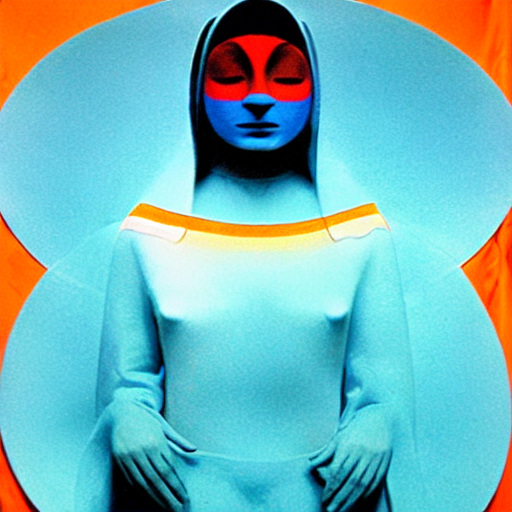

In [101]:
#prompt = 'A campfire (oil on canvas)' #
height = 512                        # default height of Stable Diffusion
width = 512                         # default width of Stable Diffusion
num_inference_steps = 50  #           # Number of denoising steps
guidance_scale = 8 #               # Scale for classifier-free guidance
generator = torch.manual_seed(64)   # Seed generator to create the inital latent noise
batch_size = 1
blue_loss_scale = 200 #

# Prep text 
text_input = tokenizer([prompt], padding="max_length", max_length=tokenizer.model_max_length, truncation=True, return_tensors="pt")
with torch.no_grad():
    text_embeddings = text_encoder(text_input.input_ids.to(torch_device))[0]

input_ids = text_input.input_ids.to(torch_device)

# Get token embeddings
token_embeddings = token_emb_layer(input_ids)

# The new embedding - our special birb word
replacement_token_embedding = x_embed['<m-geo>'].to(torch_device)

# Insert this into the token embeddings
token_embeddings[0, torch.where(input_ids[0]==replace_id)] = replacement_token_embedding.to(torch_device)

# Combine with pos embs
input_embeddings = token_embeddings + position_embeddings

#  Feed through to get final output embs
modified_output_embeddings = get_output_embeds(input_embeddings)

# And the uncond. input as before:
max_length = text_input.input_ids.shape[-1]
uncond_input = tokenizer(
    [""] * batch_size, padding="max_length", max_length=max_length, return_tensors="pt"
)
with torch.no_grad():
    uncond_embeddings = text_encoder(uncond_input.input_ids.to(torch_device))[0] 
    
text_embeddings = torch.cat([uncond_embeddings, modified_output_embeddings])

# Prep Scheduler
scheduler.set_timesteps(num_inference_steps)

# Prep latents
latents = torch.randn(
  (batch_size, unet.config.in_channels, height // 8, width // 8),
  generator=generator,
)
latents = latents.to(torch_device)
latents = latents * scheduler.init_noise_sigma

# Loop
for i, t in tqdm(enumerate(scheduler.timesteps)):
    # expand the latents if we are doing classifier-free guidance to avoid doing two forward passes.
    latent_model_input = torch.cat([latents] * 2)
    sigma = scheduler.sigmas[i]
    latent_model_input = scheduler.scale_model_input(latent_model_input, t)

    # predict the noise residual
    with torch.no_grad():
        noise_pred = unet(latent_model_input, t, encoder_hidden_states=text_embeddings)["sample"]

    # perform CFG
    noise_pred_uncond, noise_pred_text = noise_pred.chunk(2)
    noise_pred = noise_pred_uncond + guidance_scale * (noise_pred_text - noise_pred_uncond)
    
    #### ADDITIONAL GUIDANCE ###
    if i%5 == 0:
        # Requires grad on the latents
        latents = latents.detach().requires_grad_()

        # Get the predicted x0:
        # latents_x0 = latents - sigma * noise_pred
        latents_x0 = scheduler.step(noise_pred, t, latents).pred_original_sample

        # Decode to image space
        denoised_images = vae.decode((1 / 0.18215) * latents_x0).sample / 2 + 0.5 # range (0, 1)

        #ref image
        with torch.no_grad():
          ref_images = vae.decode((1 / 0.18215) * ref_latent).sample / 2 + 0.5 # range (0, 1)

        # Calculate loss
        loss = ref_loss(denoised_images,ref_images) * blue_loss_scale
        
        # Occasionally print it out
        if i%10==0:
            print(i, 'loss:', loss.item())

        # Get gradient
        cond_grad = torch.autograd.grad(loss, latents)[0]

        # Modify the latents based on this gradient
        latents = latents.detach() - cond_grad * sigma**2
    
    # Now step with scheduler
    latents = scheduler.step(noise_pred, t, latents).prev_sample


latents_to_pil(latents)[0]